<a href="https://colab.research.google.com/github/heidarimohsen92/ANPR_IR/blob/main/train_Yolov7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Tue Feb 14 07:46:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os 
import glob
import cv2
import random
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
import xml.etree.ElementTree as ET
from IPython.display import Image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!unzip /content/gdrive/MyDrive/IR_ANPR/preprocess.zip -d /content/preprocess

Mounted at /content/gdrive
Archive:  /content/gdrive/MyDrive/IR-ANPR/preprocess.zip
  inflating: /content/preprocess/custom.yaml  
  inflating: /content/preprocess/dataprocess.py  
  inflating: /content/preprocess/kaggle.json  
  inflating: /content/preprocess/yolov7_custom.yaml  


In [ ]:
!ls preprocess


custom.yaml  dataprocess.py  kaggle.json  yolov7_custom.yaml


## **Preprocces Data**

In [ ]:

# Some images do not have annotations so they are removed
def cleanup(dir_path):
    num = 0
    annotate_list = [f.split("\\")[-1][:-4] for f in glob.glob(dir_path + "/*.xml")]
    for img_path in glob.glob(dir_path + '/*.jpg'):
        img_name = img_path.split("\\")[-1][:-4]
        if img_name not in annotate_list:
            os.remove(img_path) 
            num += 1
    print (num, 'Image removed')

##############################################################################
# rename data
def rename(directory, start_name="start_name", colab=False):
    images_path = glob.glob(directory + '/*.jpg')
    idx = 1
    for img_path in images_path:
        # rename 
        if colab:
            name = img_path.split("/")[-1]
        else:
            name = img_path.split("\\")[-1]
        new_name = f"{start_name}_{str(idx).zfill(4)}.jpg"
        new_img_path = str(img_path).replace(name, new_name)
        os.rename(img_path, new_img_path)
        #rename annotation
        annot_path = str(img_path).replace(".jpg", ".xml")
        new_annot_path = str(new_img_path).replace(".jpg", ".xml")
        os.rename(annot_path, new_annot_path)
        
        idx += 1   
    print("Finished rename files" )

##############################################################################
# convert labels pascal format to yolo format
def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path, image_path):
    classes = ['car', "vehicle plate"]
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        # cls_id = classes.index(cls)
        cls_id = 0 # we have single class
        xmlbox = obj.find('bndbox')
        b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text), 
             float(xmlbox.find('ymin').text), float(xmlbox.find('ymax').text)
             )
        bb = convert((w,h), b)
        out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

def convert_pascalvoc_to_yolo(dir_path):
    output_path = dir_path + '/' 
    annotate_paths = [f for f in glob.glob(dir_path + "/*.xml")]
    for annotate_path in annotate_paths:
        convert_annotation(dir_path, output_path, annotate_path)
    print("Finished convert processing")

#############################################################################
# split data
def split_data(dir_path, threshold=0.20):
    filenames = glob.glob(os.path.join(dir_path, "*.jpg"))
    random.shuffle(filenames)
    thr = int(threshold * len(filenames))
    
    train_data = filenames[thr:]
    test_data = filenames[:thr]
    train_annotate = [str(f).replace(".jpg", ".txt") for f in train_data]
    test_annotate = [str(f).replace(".jpg", ".txt") for f in test_data]
    return train_data, train_annotate, test_data, test_annotate

##############################################################################
# move data
def moving_files(list_path, save_path, colab=False):
    for file_path in list_path:
        if colab:
            file_name = file_path.split("/")[-1]
        else:
            file_name = file_path.split("\\")[-1]
        new_path = os.path.join(save_path, file_name)
        os.rename(file_path, new_path)
        
    print("Finished moving data")

## Create directory for yolo datasets

In [ ]:
# !rm -r dataset/
# train directort
!mkdir -p /content/dataset/train/{images,labels}

# validation directort
!mkdir -p /content/dataset/val/{images,labels}

In [ ]:
# save path

# train save path
save_train_img = '/content/dataset/train/images/'
save_train_label = '/content/dataset/train/labels/'

# validation save path
save_val_img = '/content/dataset/val/images/'
save_val_label = '/content/dataset/val/labels/'


# **Concatenate  Datasets**

### Dataset 01: ALPR_Dataset

In [ ]:
# download ALPR_Dataset
!git clone https://github.com/roozbehrajabi/ALPR_Dataset.git

# moving ALPR train data to yolo dataset path
# train image
tr_img_path = "/content/ALPR_Dataset/YOLOv3_Dataset/Train/1input/"
tr_img_lst = glob.glob(os.path.join(tr_img_path, "*.jpg"))
moving_files(tr_img_lst, save_train_img, colab=True)
# train labels
tr_label_path = "/content/ALPR_Dataset/YOLOv3_Dataset/Train/1output/YOLO_darknet/"
tr_label_lst = glob.glob(os.path.join(tr_label_path, "*.txt"))
moving_files(tr_label_lst, save_train_label, colab=True)

# moving ALPR val data to yolo dataset path
# val image
val_img_path = "/content/ALPR_Dataset/YOLOv3_Dataset/Test/input/"
val_img_lst = glob.glob(os.path.join(val_img_path, "*.jpg"))
moving_files(val_img_lst, save_val_img, colab=True)
# val labels
val_label_path = "/content/ALPR_Dataset/YOLOv3_Dataset/Test/output/YOLO_darknet/"
val_label_lst = glob.glob(os.path.join(val_label_path, "*.txt"))
moving_files(val_label_lst, save_val_label, colab=True)

# remove ALPR directory
!rm -r /content/ALPR_Dataset

Cloning into 'ALPR_Dataset'...
remote: Enumerating objects: 8947, done.
remote: Total 8947 (delta 0), reused 0 (delta 0), pack-reused 8947
Receiving objects: 100% (8947/8947), 234.00 MiB | 15.05 MiB/s, done.
Resolving deltas: 100% (1646/1646), done.
Updating files: 100% (8969/8969), done.
Finished moving data
Finished moving data
Finished moving data
Finished moving data


### Download data from kaggle

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!mv /content/preprocess/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Datast 02: IranianCarsNumberPlate
https://www.kaggle.com/datasets/skhalili/iraniancarnumberplate

In [ ]:
# download dataset
!kaggle datasets download -d skhalili/iraniancarnumberplate
!unzip /content/iraniancarnumberplate.zip  
!rm -rf /content/iraniancarnumberplate.zip

icnp_path = "/content/car/"
# Some images do not have annotations so they are removed
cleanup(icnp_path)

# rename files
rename(icnp_path, start_name='icnp',  colab=True)

# convert pascal voc format to yolo format 
# (xmin, ymin, xmax, ymax) ---> (x, y, w, h)
convert_pascalvoc_to_yolo(icnp_path)

# split data
tr_img_lst, tr_label_lst, val_img_lst, val_label_lst = split_data(icnp_path, threshold=0.20)

# move train data to yolo dataset directory
moving_files(tr_img_lst, save_train_img, colab=True)
moving_files(tr_label_lst, save_train_label, colab=True)

# move val data to yolo dataset directory
moving_files(val_img_lst, save_val_img, colab=True)
moving_files(val_label_lst, save_val_label, colab=True)

# remove iraniancarnumberplate directory
!rm -r /content/car/

In [ ]:
print ('train images =', end=" ") 
!ls /content/dataset/train/images/ | wc -l 
print ('train labels =', end=" ") 
!ls /content/dataset/train/labels/ | wc -l 
print ('val images =', end=" ") 
!ls /content/dataset/val/images/ | wc -l 
print ('val labels =', end=" ") 
!ls /content/dataset/val/labels/ | wc -l 

train images = 2682
train labels = 2682
val images = 600
val labels = 600


# **YOLOV7**

In [ ]:
!git clone https://github.com/WongKinYiu/yolov7.git 

Cloning into 'yolov7'...
remote: Enumerating objects: 1127, done.
remote: Total 1127 (delta 0), reused 0 (delta 0), pack-reused 1127
Receiving objects: 100% (1127/1127), 69.94 MiB | 15.36 MiB/s, done.
Resolving deltas: 100% (521/521), done.


In [ ]:
!cd /content/yolov7/
!pip install -r /content/yolov7/requirements.txt      # install modules
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt # download pretrained weight

# **Training**

In [ ]:
%cd /content/yolov7
!python train.py --weights yolov7.pt --data /content/preprocess/custom.yaml --batch-size 16 --epochs 70 --cfg /content/preprocess/yolov7_custom.yaml --hyp data/hyp.scratch.p5.yaml


/content/yolov7
YOLOR 🚀 v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15109.875MB)

Namespace(adam=False, artifact_alias='latest', batch_size=16, bbox_interval=-1, bucket='', cache_images=False, cfg='/content/preprocess/yolov7_custom.yaml', data='/content/preprocess/custom.yaml', device='', entity=None, epochs=70, evolve=False, exist_ok=False, freeze=[0], global_rank=-1, hyp='data/hyp.scratch.p5.yaml', image_weights=False, img_size=[640, 640], label_smoothing=0.0, linear_lr=False, local_rank=-1, multi_scale=False, name='exp', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/exp', save_period=-1, single_cls=False, sync_bn=False, total_batch_size=16, upload_dataset=False, v5_metric=False, weights='yolov7.pt', workers=8, world_size=1)
tensorboard: Start with 'tensorboard --logdir runs/train', view at http://localhost:6006/
2023-02-14 07:48:11.524729: I tensorflow/core/platform/cpu_feature_guard.cc:193

# **Testing**

In [ ]:
!python test.py --data /content/preprocess/custom.yaml --weights /content/yolov7/runs/train/exp/weights/best.pt

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='/content/preprocess/custom.yaml', device='', exist_ok=False, img_size=640, iou_thres=0.65, name='exp', no_trace=False, project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_txt=False, single_cls=False, task='val', v5_metric=False, verbose=False, weights=['/content/yolov7/runs/train/exp/weights/best.pt'])
YOLOR 🚀 v0.1-121-g2fdc7f1 torch 1.13.1+cu116 CUDA:0 (Tesla T4, 15109.875MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36481772 parameters, 6194944 gradients, 103.2 GFLOPS
 Convert model to Traced-mod

# **Result**

## **Plot F1_curve**

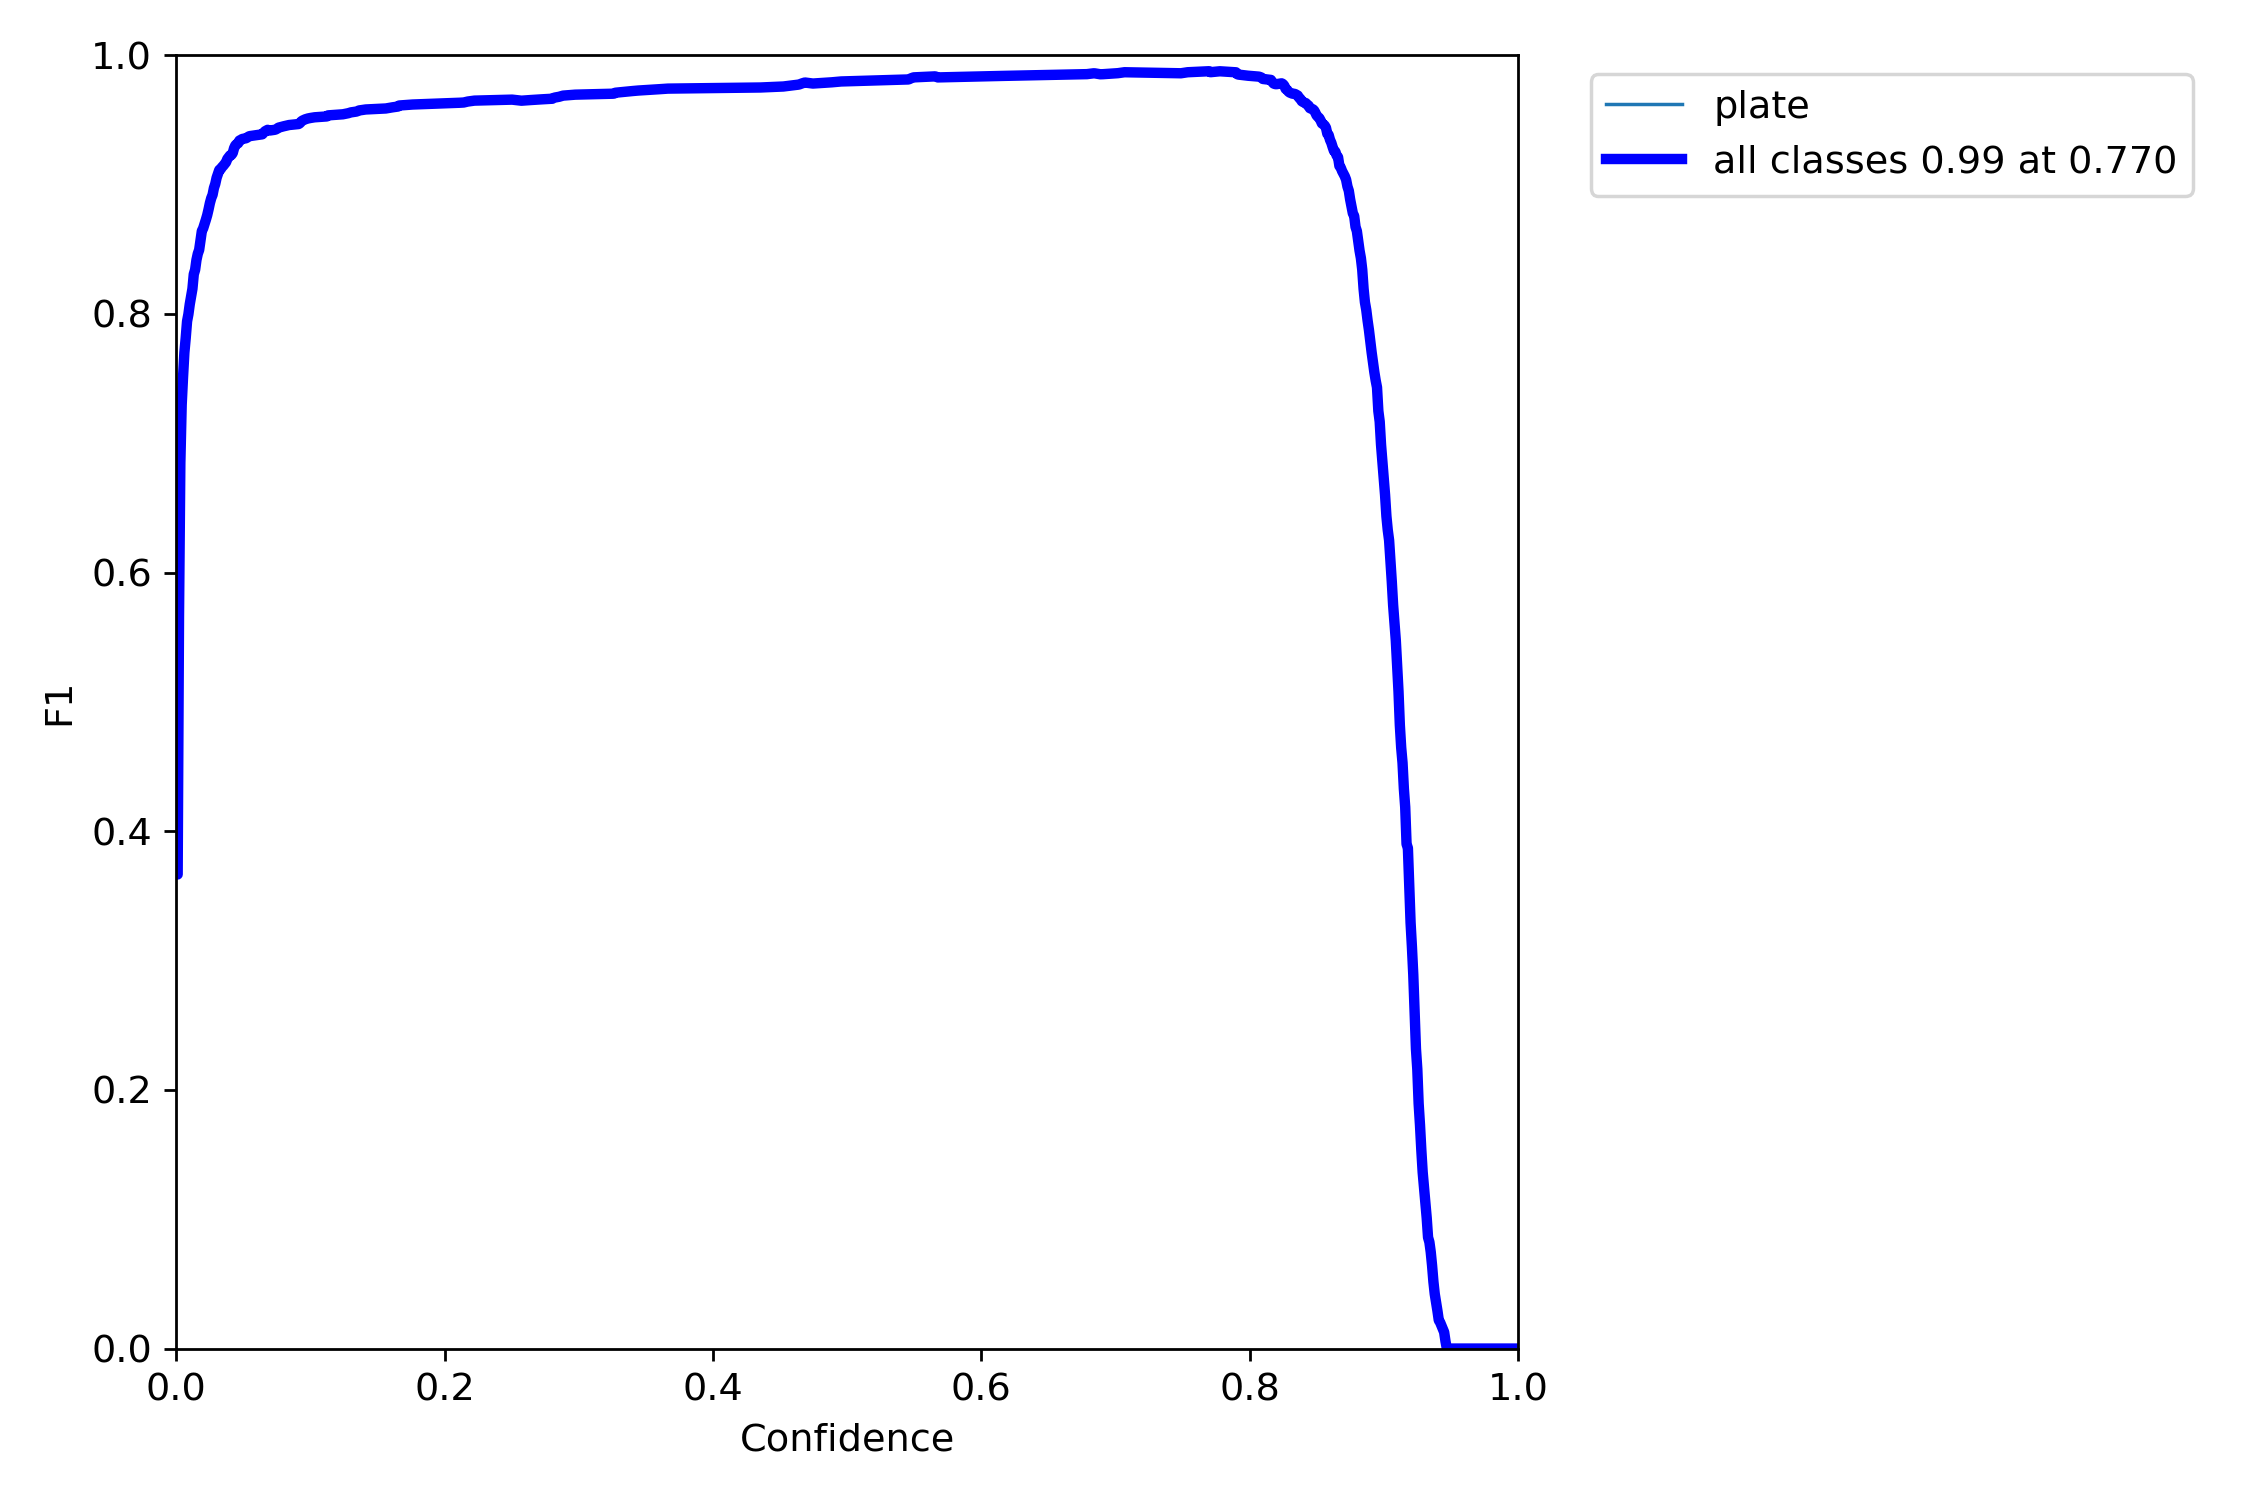

In [ ]:
# F1_curve
display(Image("/content/yolov7/runs/train/exp/F1_curve.png", width=600, height=400))

## **Plot Precision-Recall curve**

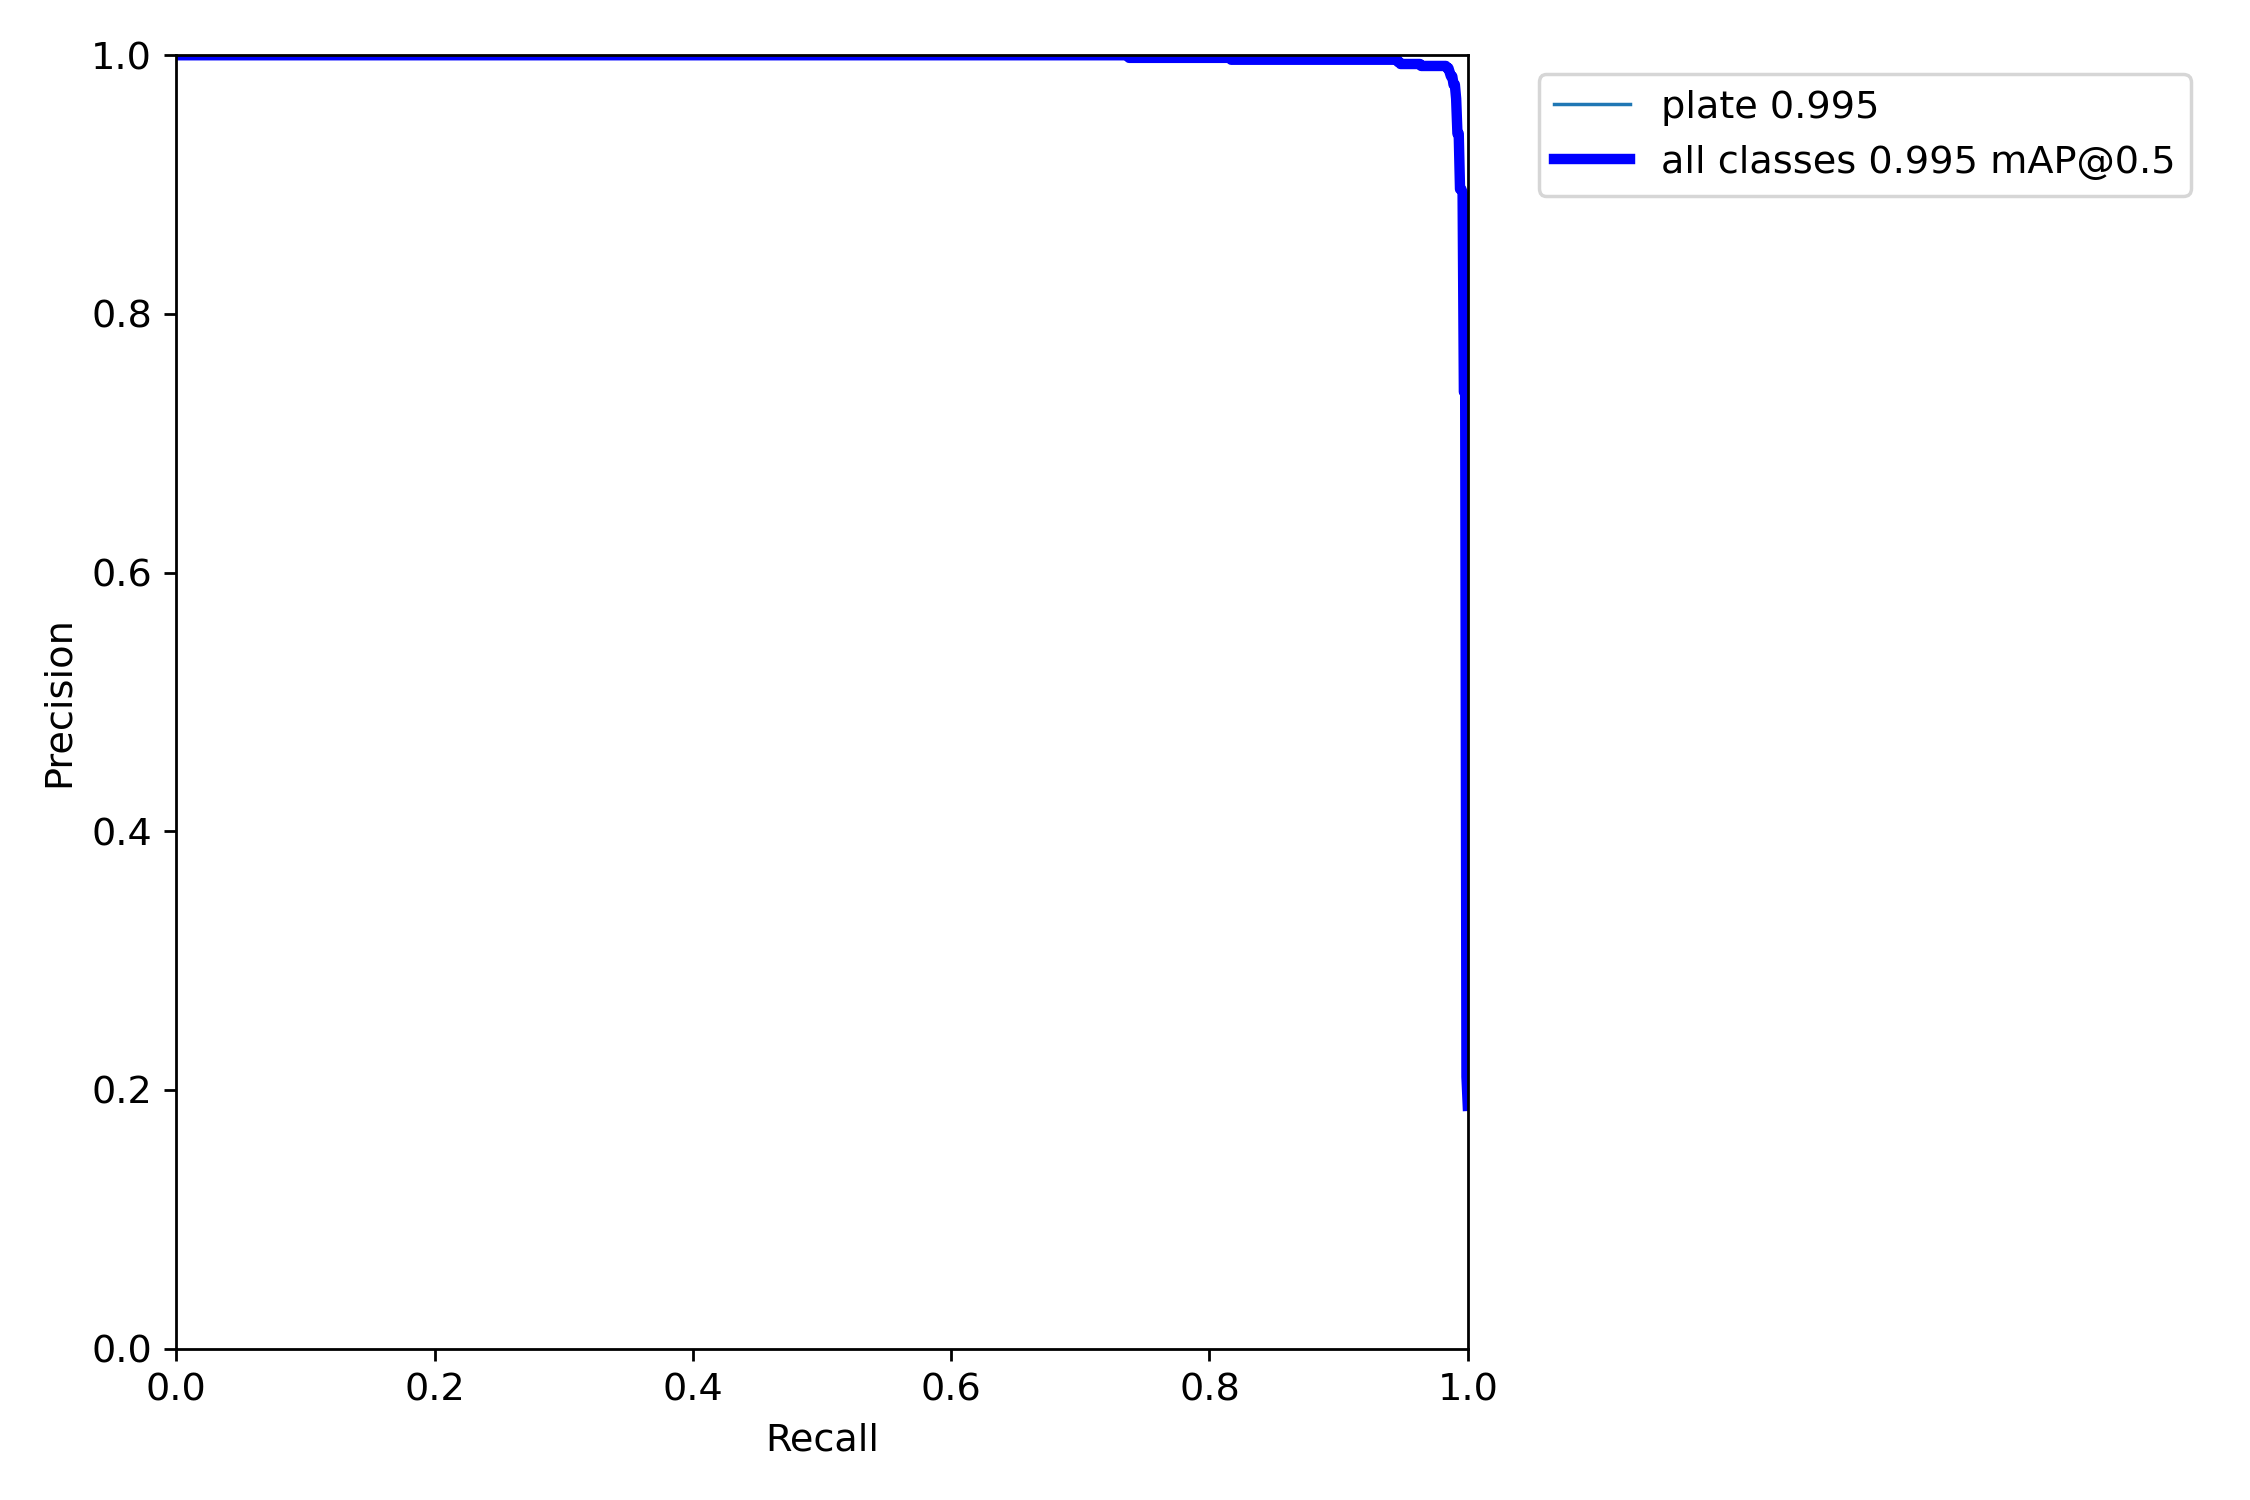

In [ ]:
# PR_curve
display(Image("/content/yolov7/runs/train/exp/PR_curve.png", width=600, height=400))

## **Plot Precision curve**

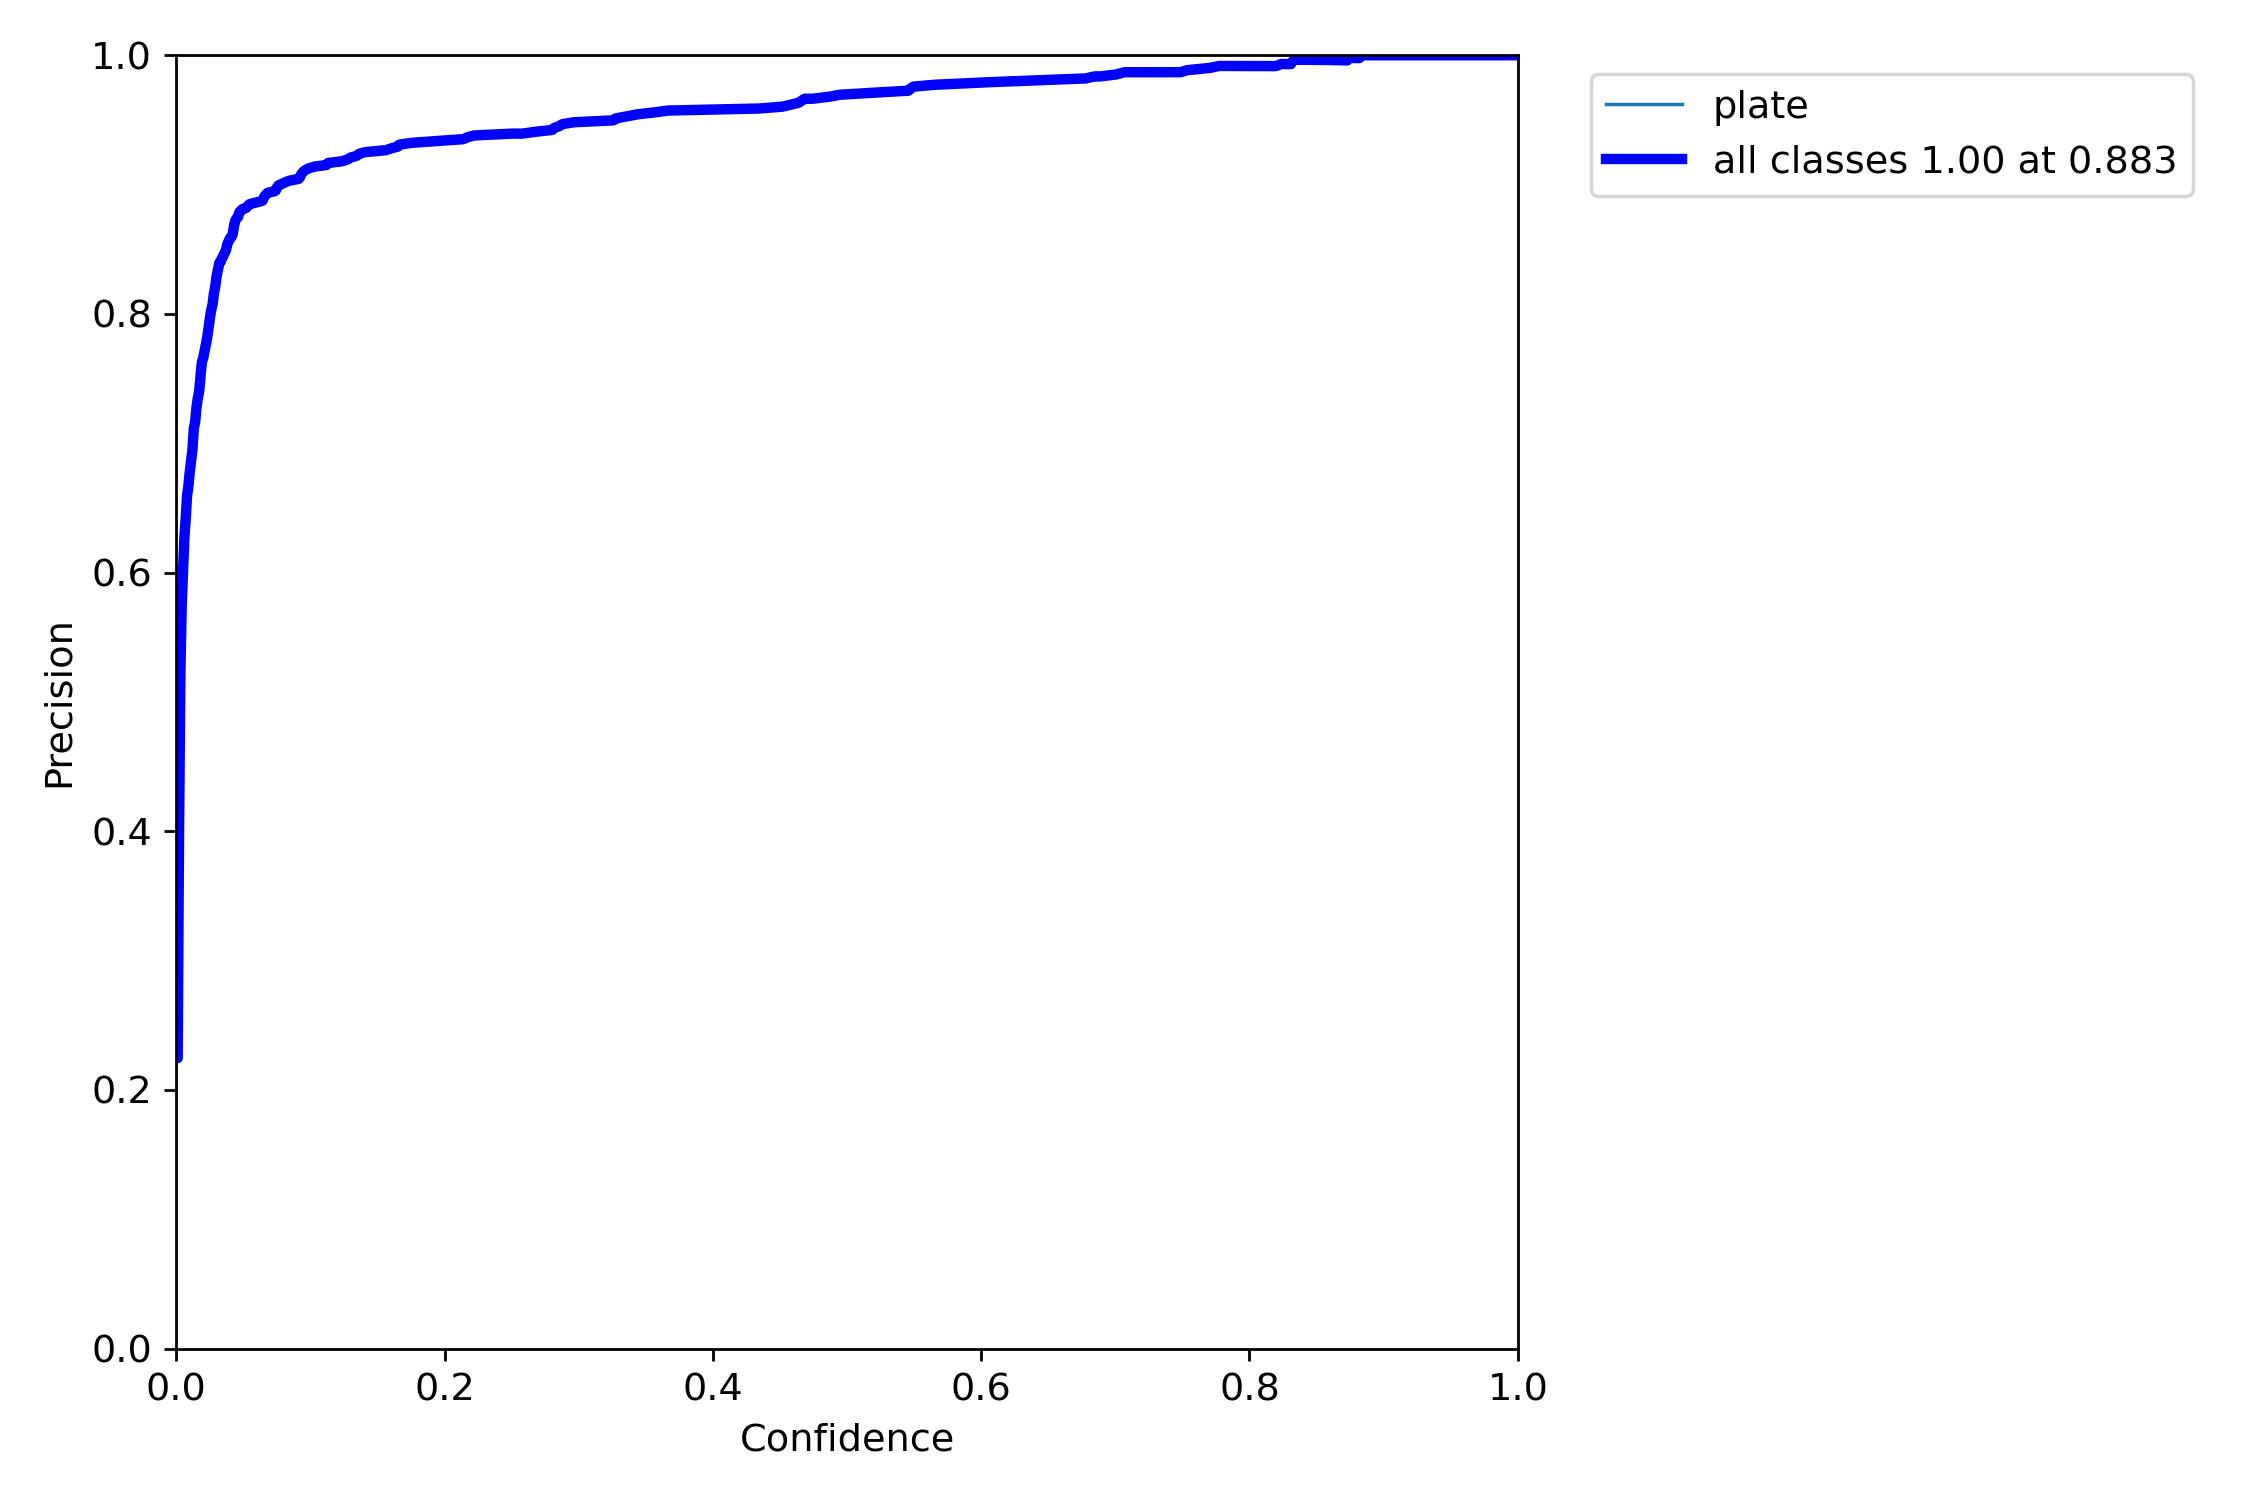

In [ ]:
# P_curve
display(Image("/content/yolov7/runs/train/exp/P_curve.png", width=600, height=400))

## **Plot Recall curve**

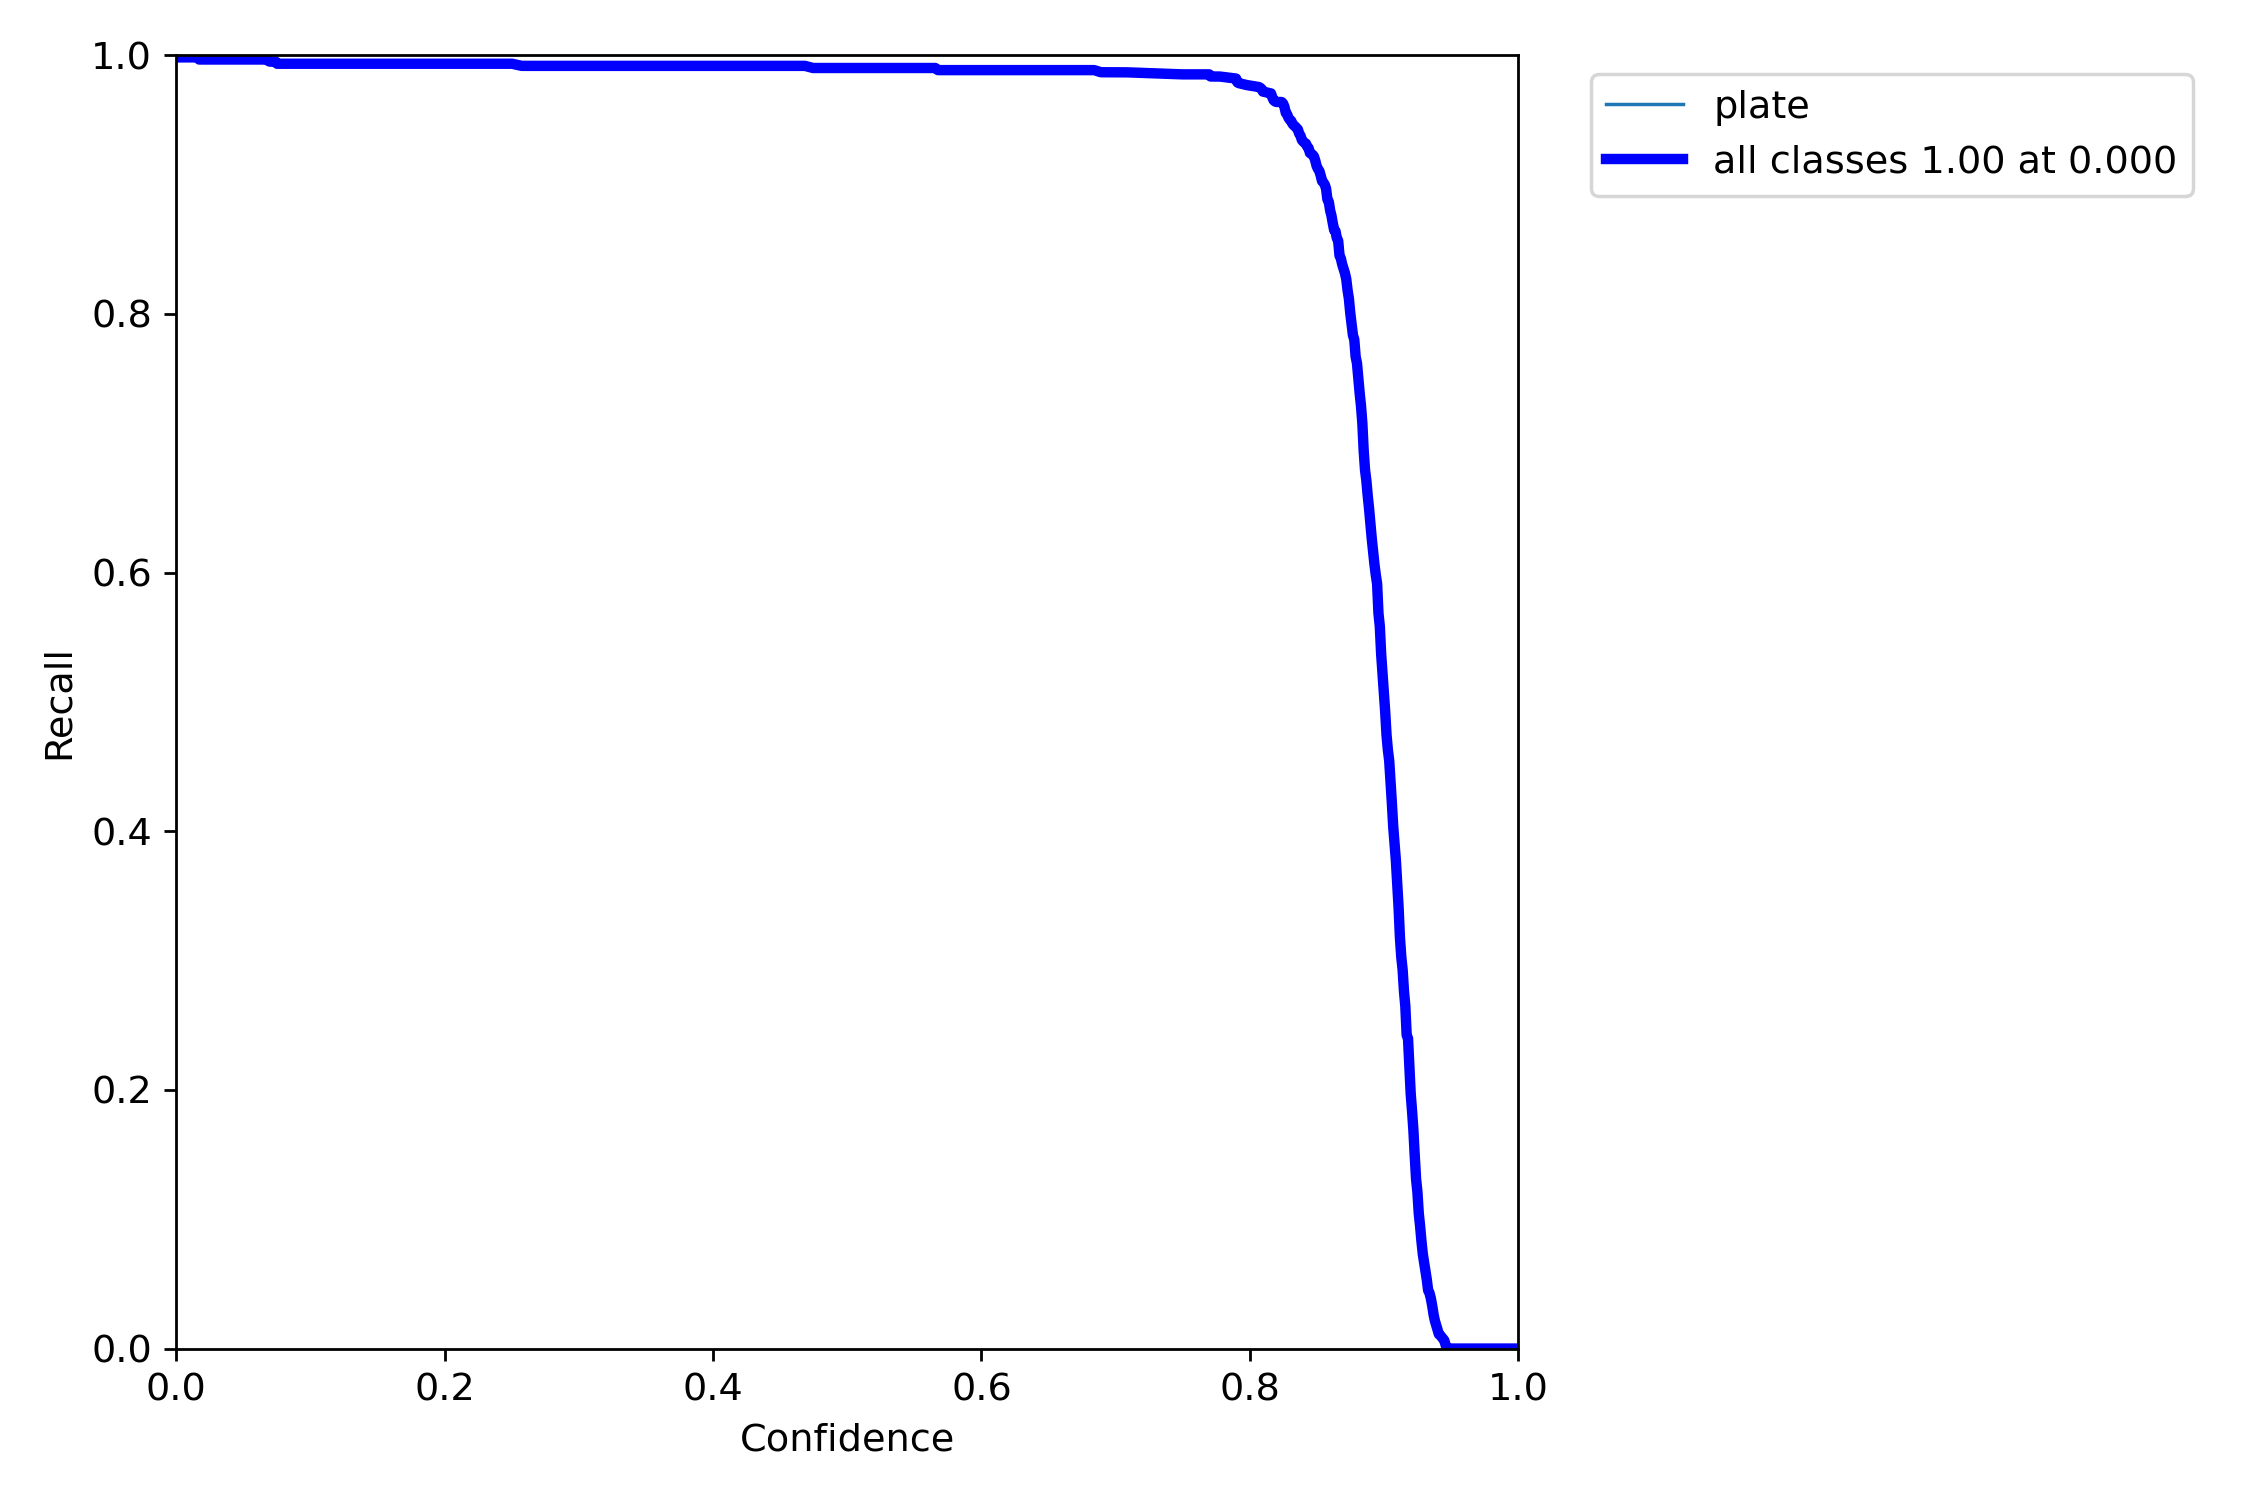

In [ ]:
# R_curve
display(Image("/content/yolov7/runs/train/exp/R_curve.png", width=600, height=400))

## **Plot confusion_matrix**

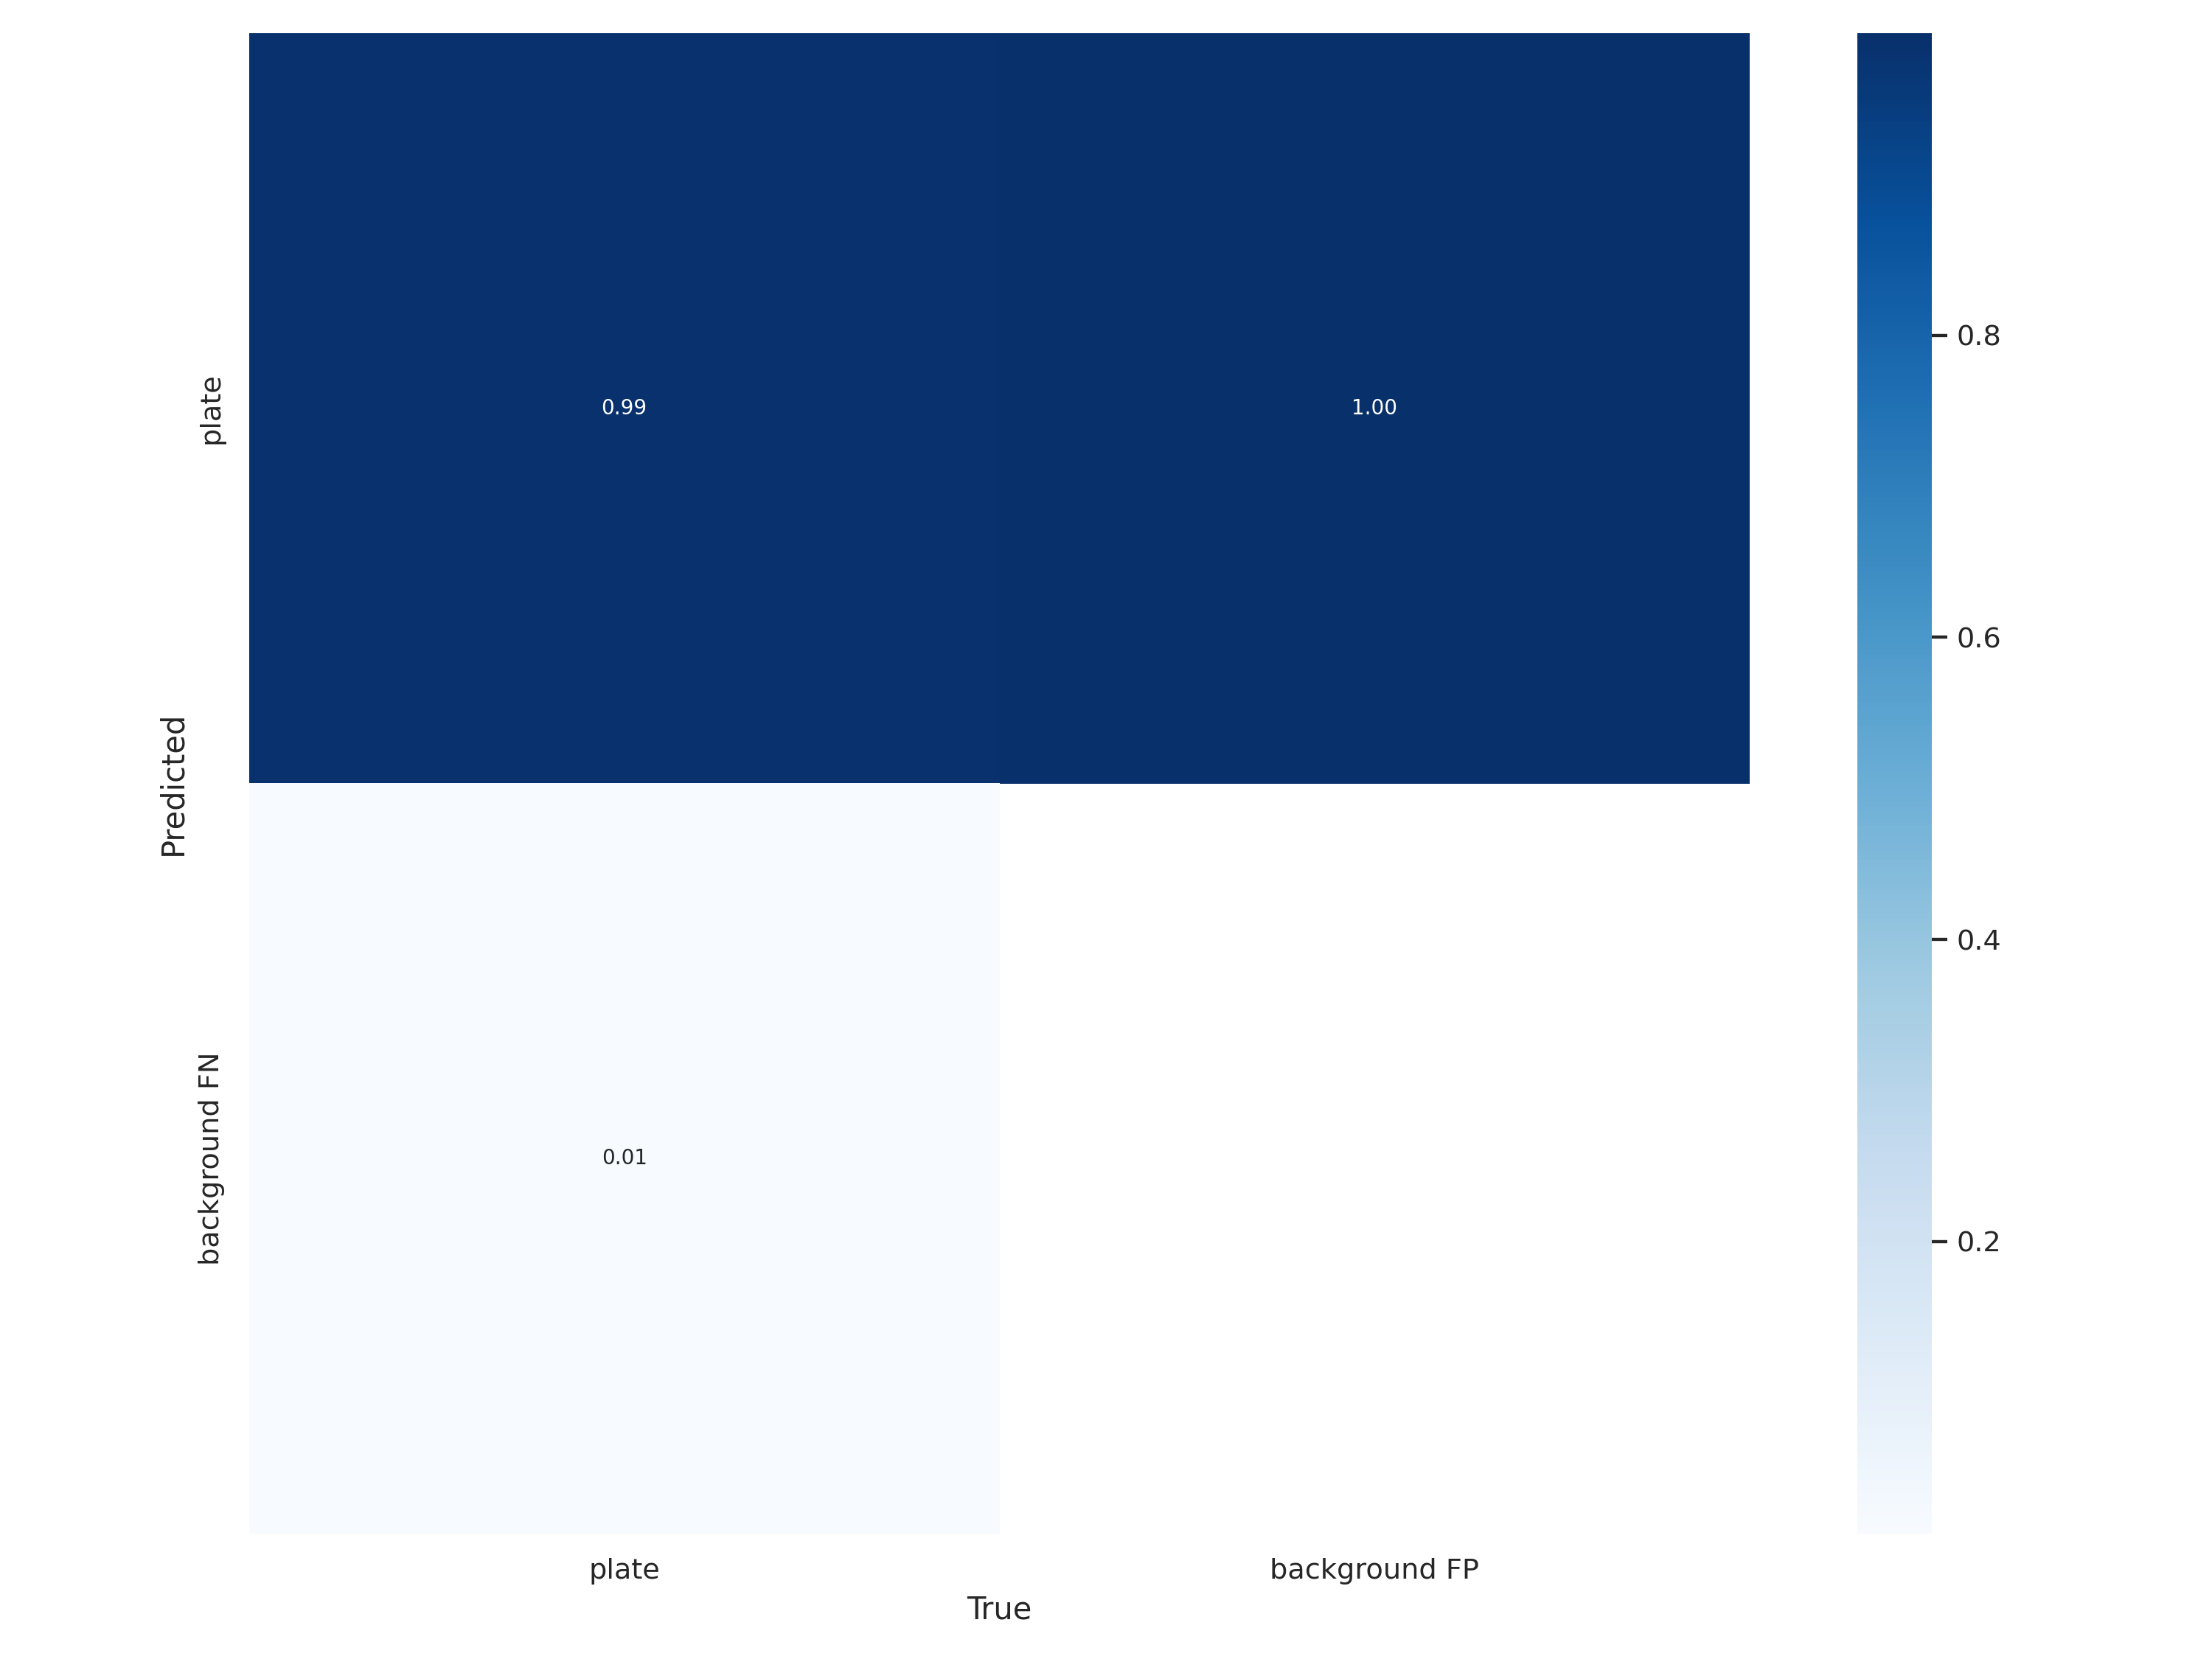

In [ ]:
# confusion_matrix
display(Image("/content/yolov7/runs/train/exp/confusion_matrix.png", width=700, height=700))

## **Plot Results**

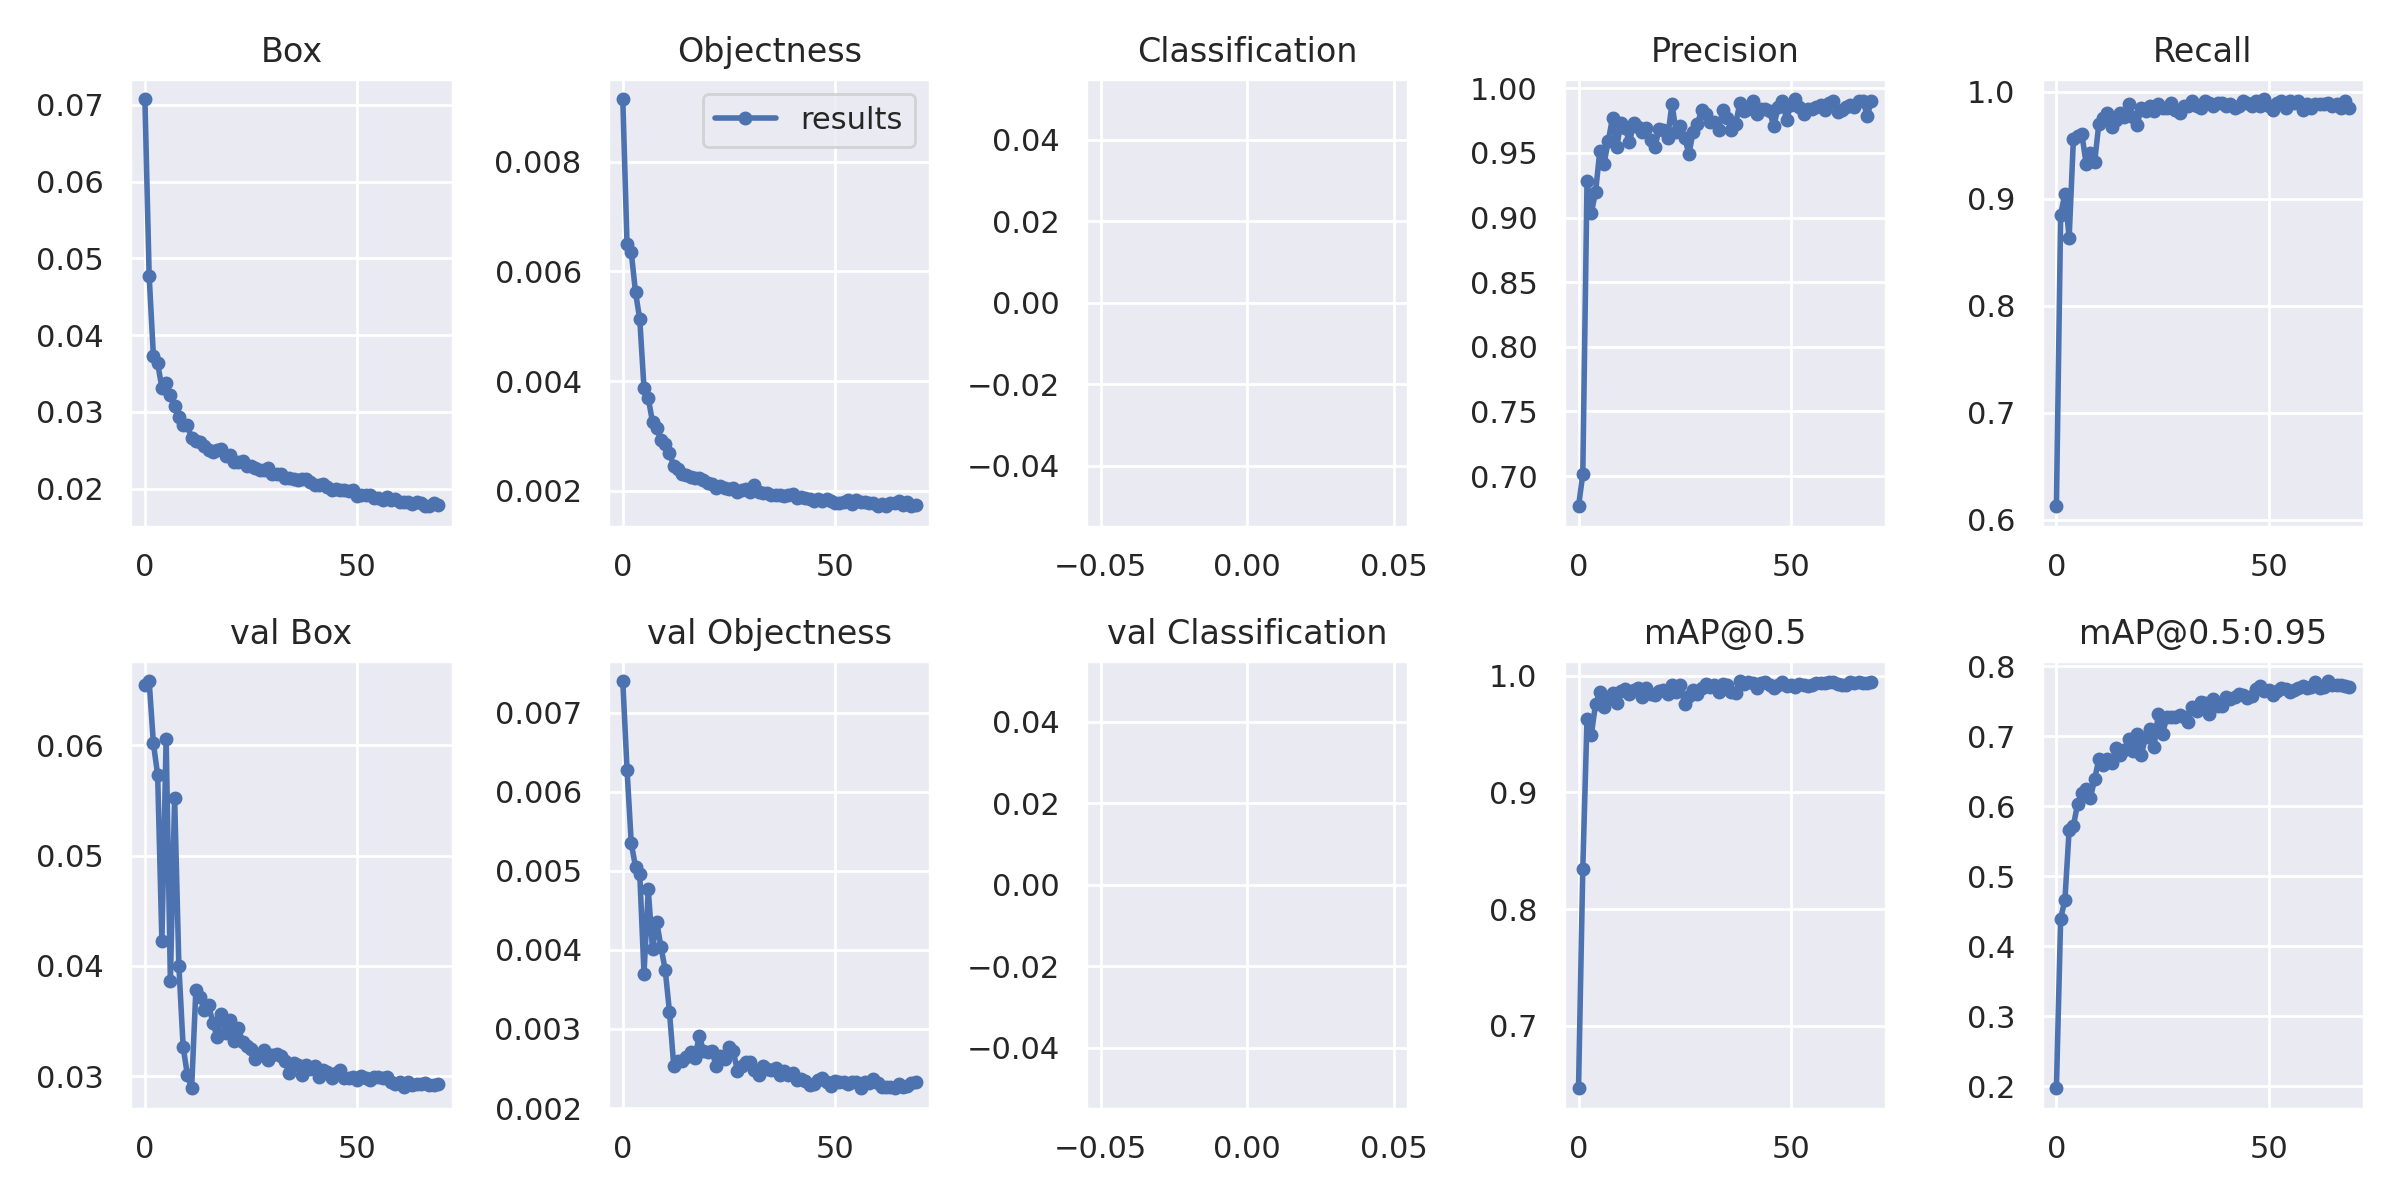

In [ ]:
# results
display(Image("/content/yolov7/runs/train/exp/results.png", width=1000, height=500))

## Plot Test images

 labels


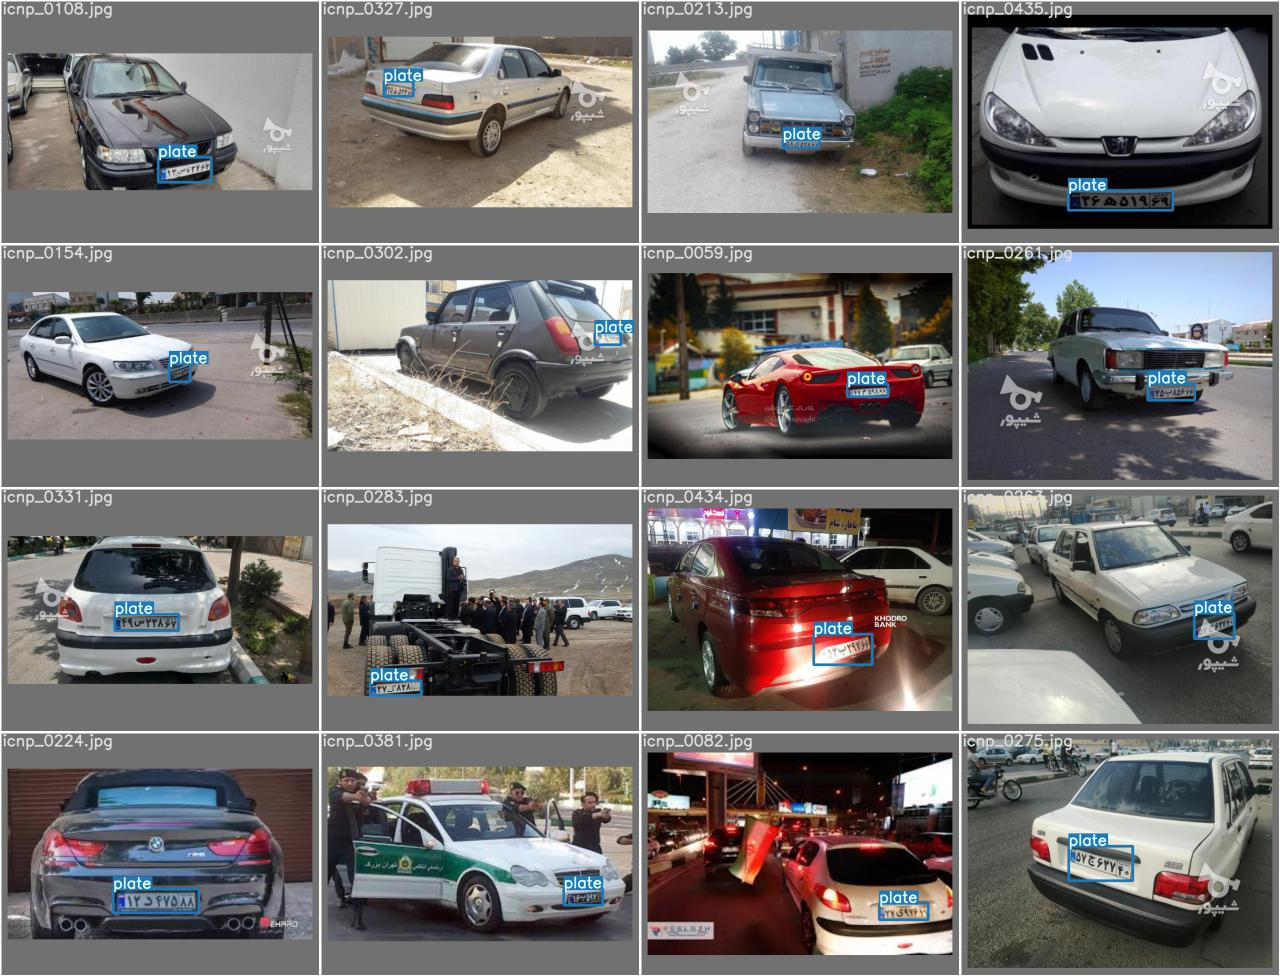



 pred


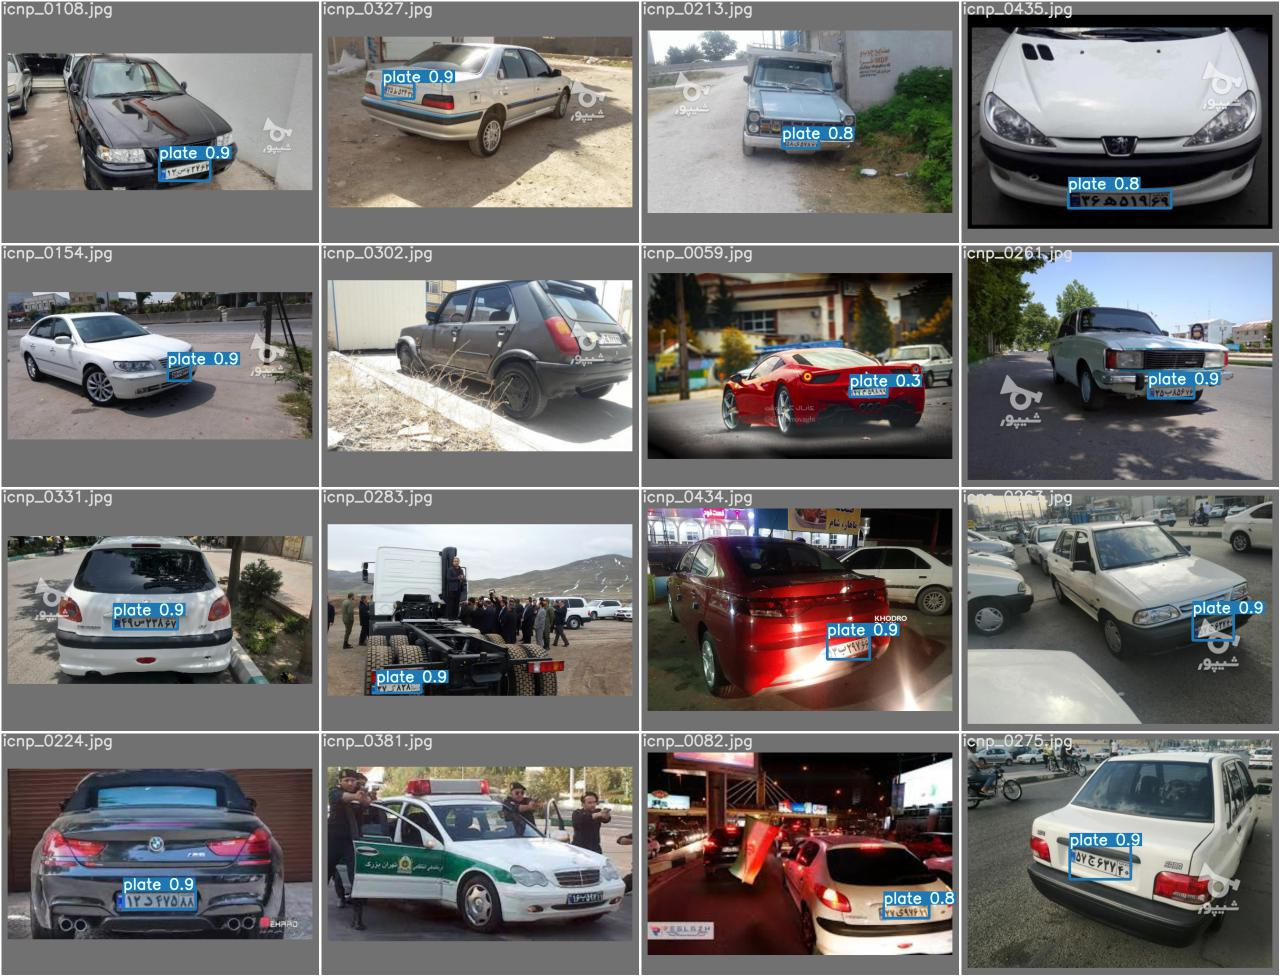

In [ ]:
print (" labels")
display(Image("/content/yolov7/runs/train/exp/test_batch0_labels.jpg", width=800, height=700))

print ("\n\n pred")
display(Image("/content/yolov7/runs/train/exp/test_batch0_pred.jpg", width=800, height=700))

# **save weights**

In [ ]:
from google.colab import files
files.download('/content/yolov7/runs/train/exp/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>